In [12]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import scale

In [13]:
df = pd.read_csv('data_vectorized_2709_doctr_trad', sep = '\t')
df = df.fillna(' ')

In [14]:
from nltk.tokenize import PunktSentenceTokenizer, word_tokenize
import nltk
#nltk.download('punkt')
tokenizer = PunktSentenceTokenizer()

mots = []
for i in range(df.shape[0]):
    texte = str(df['mots_doctr_trad'][i])
    tokenizer.tokenize(texte)
    mots.append(word_tokenize(texte, language = 'french'))
      
df['mots'] = mots

On cherche à analyser les résultats du modèle obtenu précédemment :

In [4]:
# pip install shap
# pip install skater

In [15]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from imblearn import over_sampling
from sklearn.ensemble import RandomForestClassifier
import shap
%matplotlib inline

Pour rappel, on va d'abord afficher les résultats du modèle optimal :

In [16]:
X = df.mots_doctr_trad
y = df.type_num

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 42)

vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test).todense()

ro = over_sampling.RandomOverSampler()
X_ro, y_ro = ro.fit_resample(X_train, y_train)



In [17]:
from sklearn.linear_model import LogisticRegression
clf_lr = LogisticRegression(n_jobs = -1, C= 17.78279410038923, solver= 'lbfgs', random_state=22)

clf_lr.fit(X_ro, y_ro);
y_pred=clf_lr.predict(X_test)
print(classification_report(y_test, y_pred, target_names = df.type.unique().tolist()))


                 precision    recall  f1-score   support

        facture       0.93      1.00      0.97        14
      id_pieces       1.00      0.95      0.97        20
justif_domicile       1.00      0.67      0.80         3
      passeport       1.00      0.88      0.93         8
           paye       0.97      0.91      0.94        34
  carte postale       0.83      0.62      0.71        16
 scientific_doc       0.61      0.99      0.75        67
           form       1.00      0.50      0.67         2
  advertisement       1.00      0.12      0.22         8
         letter       1.00      0.20      0.33         5
         resume       1.00      0.71      0.83         7
  specification       0.80      1.00      0.89         4
           memo       0.00      0.00      0.00         3
        invoice       0.67      0.50      0.57         4
         budget       1.00      0.25      0.40         4
   news_article       0.80      0.50      0.62         8
   presentation       1.00    

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


<AxesSubplot:title={'center':'Heatmap sans limiter le nombre de features'}, xlabel='Classe prédite', ylabel='Classe réelle'>

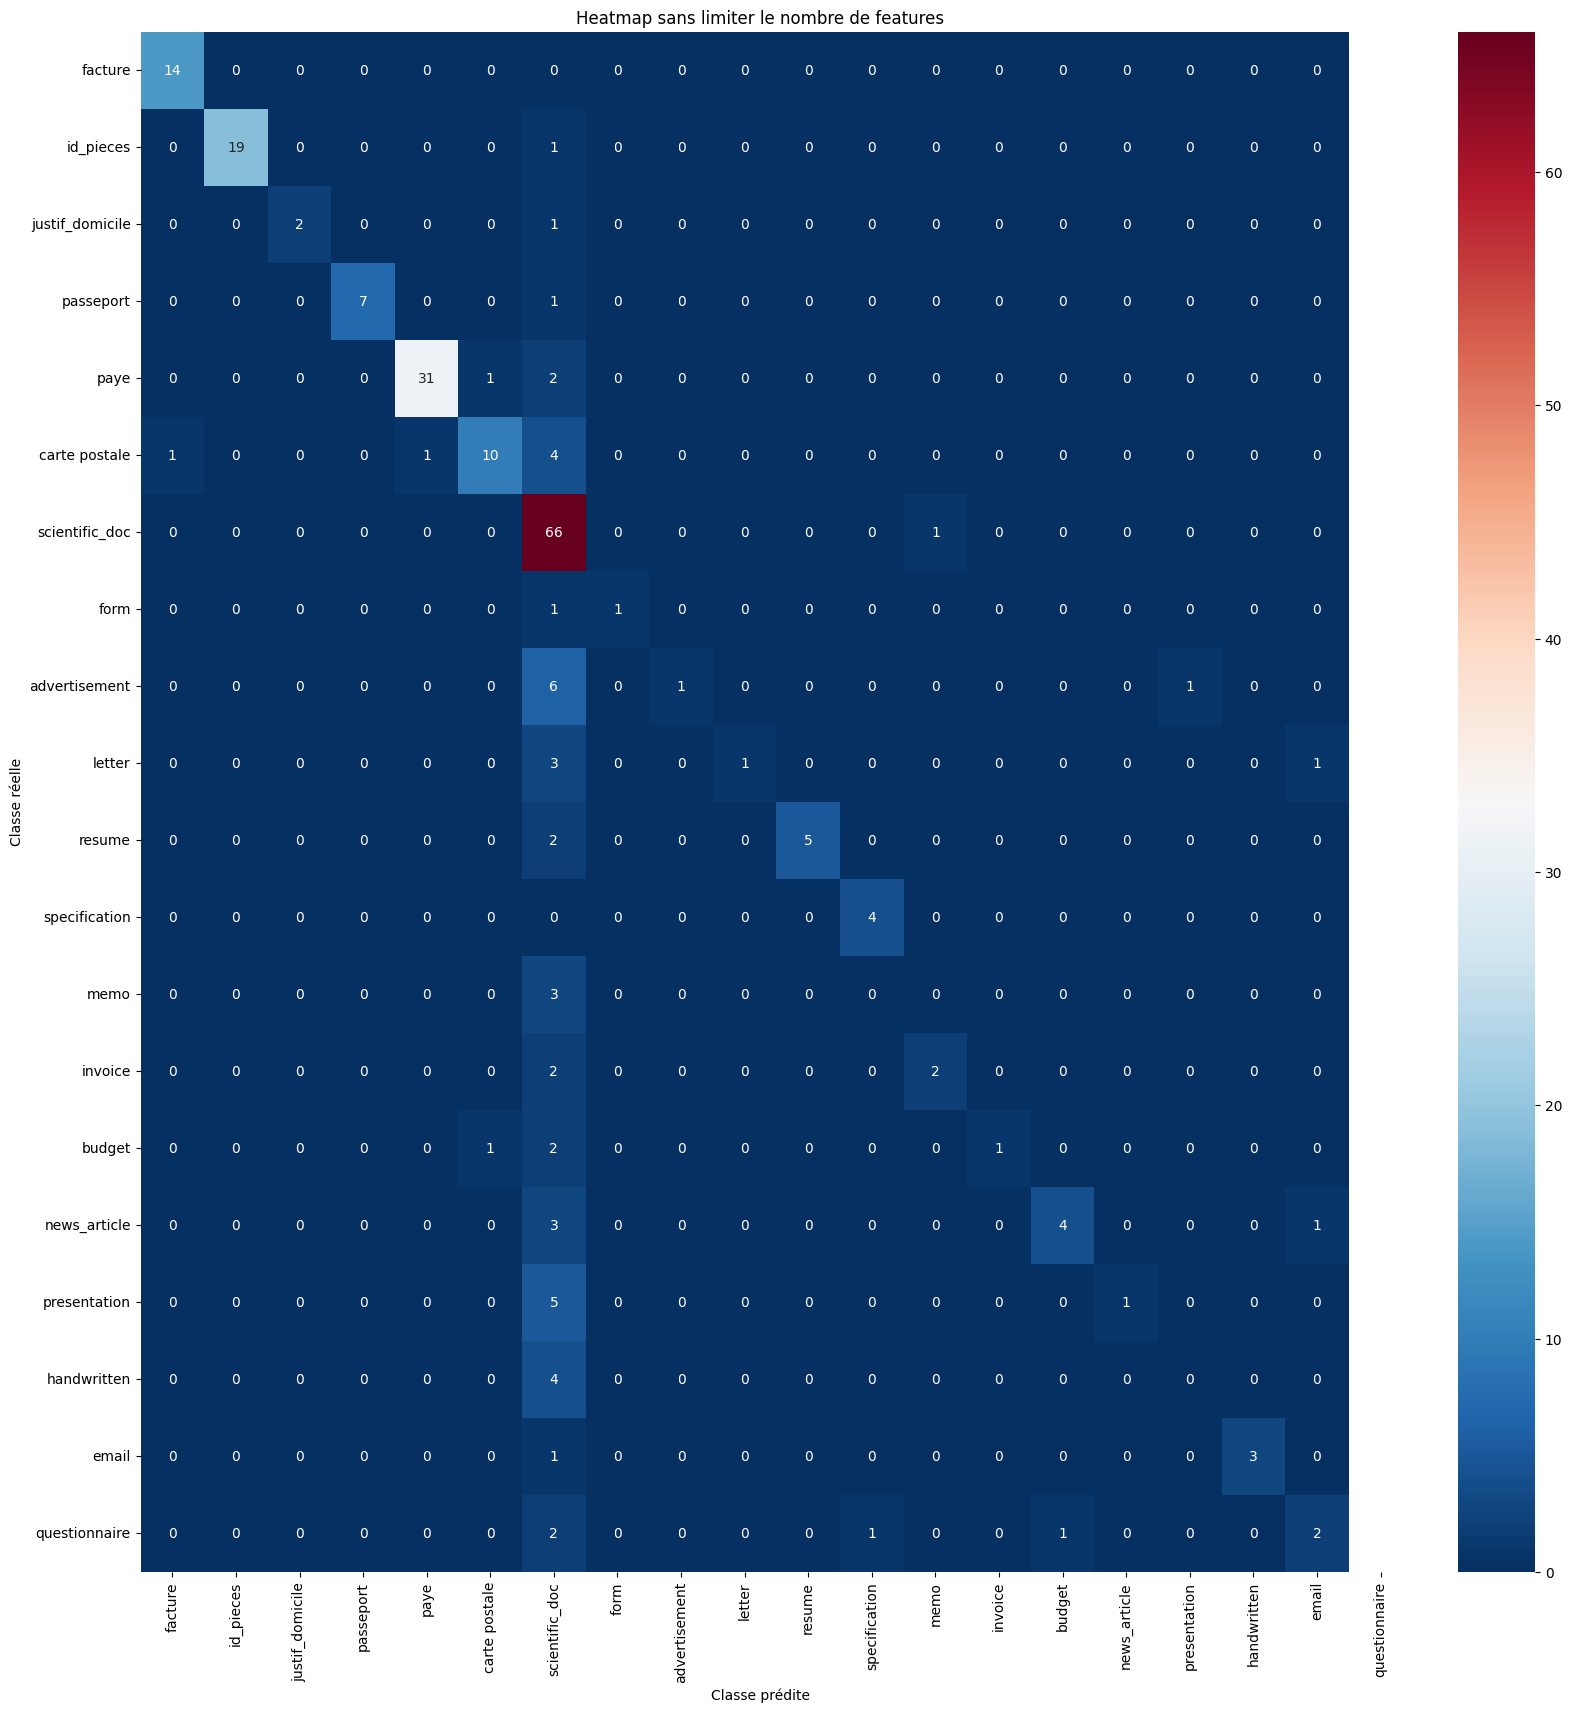

In [18]:
heatmap = pd.crosstab(y_test, y_pred, rownames = ['Classe réelle'], colnames = ['Classe prédite'])
import seaborn as sns
plt.figure(figsize = (20,20))
plt.title('Heatmap sans limiter le nombre de features')
sns.heatmap(heatmap, annot = True, cmap = "RdBu_r", xticklabels = df.type.unique().tolist(), yticklabels = df.type.unique().tolist())

Le nombre de features utilisées par le vectorizer est le suivant :

In [19]:
len(vectorizer.get_feature_names())

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


24293

On va chercher le nombre de features optimal à utiliser :

In [20]:
#On cherche à limiter le nombre de feature pour avoir un nombre raisonnable de variable à analyser, sans perdre trop d'accuracy:
liste = []
for i in range(1000,24000,1000):
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 42)
    vectorizer = TfidfVectorizer(max_features = i)
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test).todense()
    ro = over_sampling.RandomOverSampler()
    X_ro, y_ro = ro.fit_resample(X_train, y_train)
    clf_lr = LogisticRegression(n_jobs = -1, C= 17.78279410038923, solver= 'lbfgs', random_state=22)
    clf_lr.fit(X_ro, y_ro);
    liste.append(clf_lr.score(X_test, y_test))

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information se

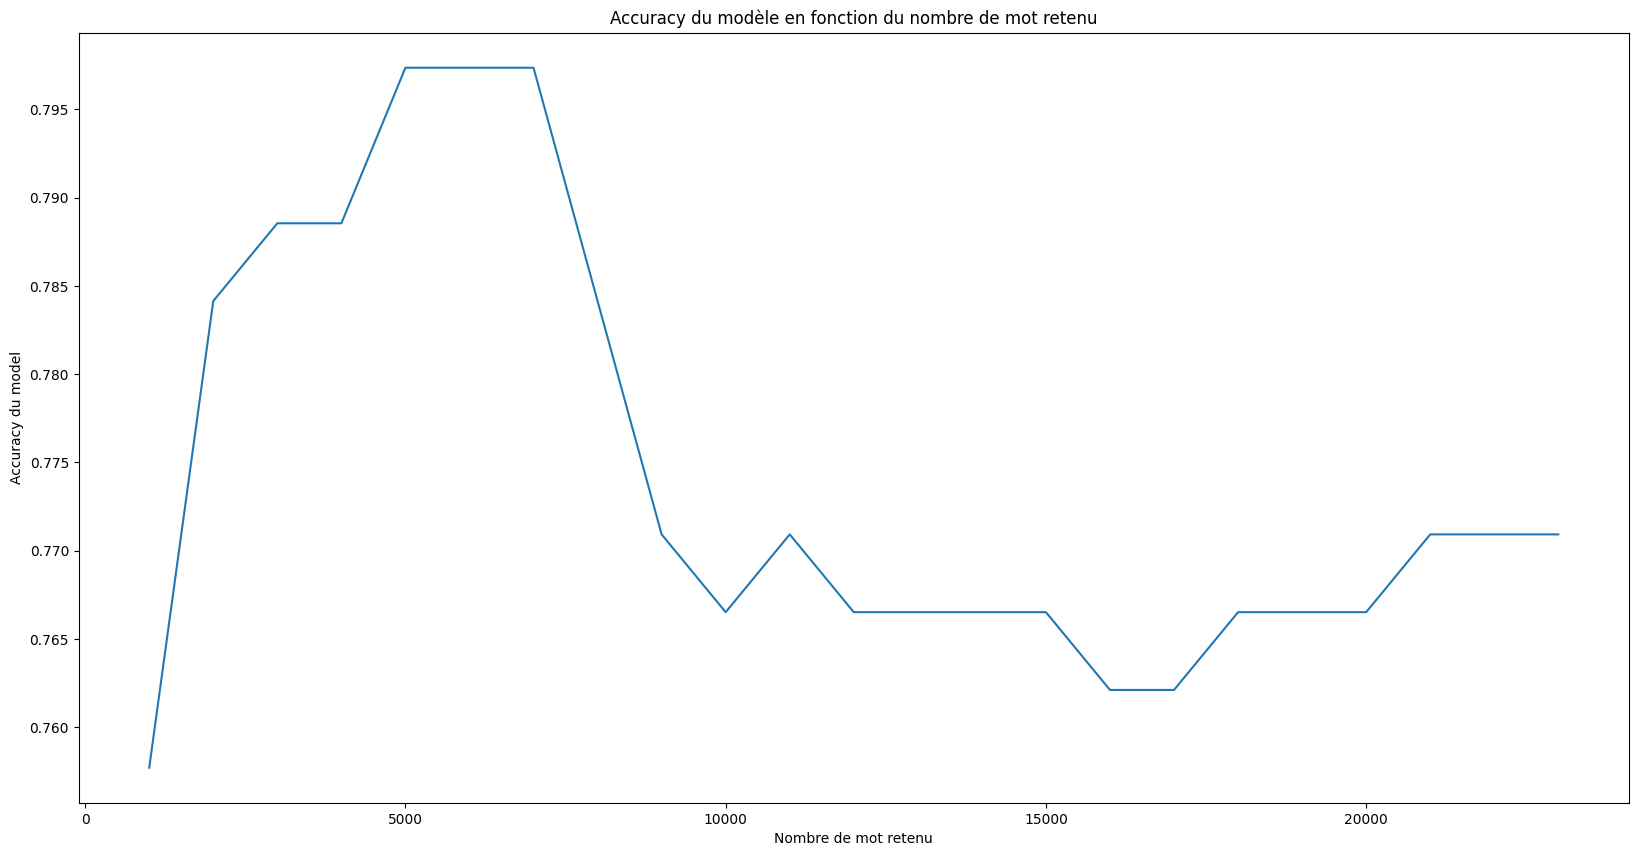

In [21]:
plt.figure(figsize = (20,10))
plt.xlabel('Nombre de mot retenu')
plt.ylabel('Accuracy du model')
plt.title('Accuracy du modèle en fonction du nombre de mot retenu')
plt.plot([i for i in range(1000,24000,1000)], liste);

#Pour la suite, on va retenir max_feature = 5000

On voit que l'optimum se situe à un nombre de features = 5000.

In [22]:
X = df.mots_doctr_trad
y = df.type_num
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2)
vectorizer = TfidfVectorizer(max_features = 5000)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test).todense()
ro = over_sampling.RandomOverSampler()
X_ro, y_ro = ro.fit_resample(X_train, y_train)
clf_lr = LogisticRegression(n_jobs = -1, C= 17.78279410038923, solver= 'lbfgs', random_state=22)
clf_lr.fit(X_ro, y_ro);
y_pred = clf_lr.predict(X_test)


np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html


A partir de là, on peut recréer un tableau n'utilisant que les features prises en compte par le modèle :

In [23]:
X_train_df = pd.DataFrame(X_train.todense()) #On converti X_train en dataframe

In [24]:
#On renomme les colonnes de X_train pour savoir quels sont les mots retenus
dic ={}
liste_column = vectorizer.get_feature_names()
for i in range(X_train_df.shape[1]):
    dic.update({X_train_df.columns[i] : liste_column[i]})

X_train_df = X_train_df.rename(columns = dic)
X_train_df.head()

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


,aaaaaaaaa,aad,aair,aat,abbott,abbreviation,abc,abcdfrp,ability,able,...,yyyy,zahlsen,zaventem,zeit,zip,zon,zoology,zur,zwischen,être
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.073942,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
X_train_df.shape

(907, 5000)

Et on peut sommer + trier celui-ci afin d'obtenir les 20 features prépondérantes dans notre analyse :

In [26]:
X_train_df.sum().sort_values(ascending = False)[:20]


name         25.151617
date         23.129281
pay          17.572432
total        17.283807
number       14.539206
amount       12.976413
tobacco      12.972412
of           12.547865
tax          12.266408
new          12.132690
time         12.076534
source       11.978098
french       11.484095
use          11.437210
the          11.337254
net          11.146638
cigarette    10.897056
map          10.882522
bill         10.705840
national     10.590166
dtype: float64

Après les quelques itérations faites (retour sur le notebook 3 pour ajouter aux stopwords les mots "the", "in", "and" ou "this), ainsi que l'itération faite au début de ce notebook pour retirer tous les nombres, les 20 mots les plus courants semblent à présent être plus pertinents.

In [27]:
importances = clf_lr.coef_
feature_list = [X_train_df.columns[f] for f in range(X_train_df.shape[1])]  #names of features.
ff = np.array(feature_list)

In [28]:
def class_feature_importance(X, Y, feature_importances):
    N,M = X.shape
    X = scale(X)
    out = {}
    for c in set(Y):
        out[c] = dict(zip(range(M), np.mean(X[Y==c, :], axis = 0)*feature_importances))
    return out

#On multiplie la moyenne standardisée pour chaque features groupé par catégorie, on et multiplie cette valeur par la feature_importance

In [29]:
result = class_feature_importance(pd.DataFrame(X_train_df).values,y_train, clf_lr.coef_ )    
len(result)

20

# Test d'interprétabilité utilisant Shap.

In [54]:
explainer = shap.LinearExplainer(clf_lr, X_train, feature_perturbation="interventional")

shap_values = explainer.shap_values(X_test)

#shap.initjs()

#shap.force_plot(explainer.expected_value[1], shap_values[1])

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[:10], X_test[:10])

## Essai d'implémentation d'un BERT - NER

On va essayer d'implémenter un modèle de NER - Name Entity Recognition.

In [31]:
#pip install transformers

In [32]:
from transformers import pipeline
ner_pipe = pipeline("ner")

No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Downloading:   0%|          | 0.00/998 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some layers from the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing TFBertForTokenClassification: ['dropout_147']
- This IS expected if you are initializing TFBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForTokenClassification were initialized from the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForTokenClassification for predictions without further training.


Downloading:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

In [55]:
df2 = pd.read_csv('data_OCR_2109.txt', sep = '\t')

for i in range(df2.shape[0]):
    if (df2['width'][i] <= 400) | (df2['height'][i] <= 400) | (df2['size'][i] <= 20000):
        df2 = df2.drop(i, axis = 0)
        
df2 = df2.reset_index().drop('index', axis = 1)
df2 = df2.drop('transcript', axis = 1)

r2 = re.compile(r"[^a-zA-Zéèàùôâêëäïöü]")
for i in range(df2.shape[0]):
    df2['transcript_Doctr'][i] = r2.sub(' ', str(df2['transcript_Doctr'][i]))

df2.head()


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,filename,type,size,width,height,transcript_Doctr
0,img_0000000.jpg,facture,59453,750,1061,FACTURE LOGO Joanna Binet Coubertin P...
1,img_0000001.jpg,facture,55157,750,1061,Joanna Binet Coubertin Paris FACTURE ...
2,img_0000002.jpg,facture,32097,726,1024,FACTURE Mon entreprise Nom de la société Adr...
3,img_0000003.jpg,facture,63937,750,1061,Joanna Binet Coubertin Paris FACTURE ...
4,img_0000004.jpg,facture,79474,773,771,Payer en ligne FACTURE No SFIDELI F ...


On enlève du dataset les documents sur lesquels moins de 10 mots ont été détectés.

In [56]:
for i in range(df2.shape[0]):
    if len(df2['transcript_Doctr'][i]) < 10:
        df2 = df2.drop(i, axis = 0)
df2 = df2.reset_index().drop('index', axis = 1)


Ensuite, afin de tester les capacités de notre modèle, on va le tester sur les premiers documents.
On ne conserve que les entités pour lesquelles le modèle a une confiance > 0.9, et plus longues que 2 caractères.

In [60]:
for entity in ner_pipe(df2['transcript_Doctr'][0]):
    if (entity['score'] > 0.90) & (entity['end'] - entity['start'] > 2):
        print(entity)

{'entity': 'I-PER', 'score': 0.9453933, 'index': 9, 'word': 'Joanna', 'start': 13, 'end': 19}
{'entity': 'I-PER', 'score': 0.95277625, 'index': 10, 'word': 'Bin', 'start': 20, 'end': 23}


In [61]:
for entity in ner_pipe(df2['transcript_Doctr'][1]):
    if (entity['score'] > 0.90) & (entity['end'] - entity['start'] > 2):
        print(entity)

{'entity': 'I-PER', 'score': 0.9556251, 'index': 1, 'word': 'Joanna', 'start': 0, 'end': 6}
{'entity': 'I-PER', 'score': 0.95562685, 'index': 2, 'word': 'Bin', 'start': 7, 'end': 10}
{'entity': 'I-LOC', 'score': 0.988482, 'index': 48, 'word': 'France', 'start': 155, 'end': 161}


In [62]:
for entity in ner_pipe(df2['transcript_Doctr'][3]):
    if (entity['score'] > 0.90) & (entity['end'] - entity['start'] > 2):
        print(entity)

{'entity': 'I-PER', 'score': 0.91648906, 'index': 1, 'word': 'Joanna', 'start': 0, 'end': 6}
{'entity': 'I-LOC', 'score': 0.93700075, 'index': 44, 'word': 'France', 'start': 147, 'end': 153}


On peut voir que le modèle fonctionne assez bien.

On va donc chercher à le généraliser à tout le dataframe, en créant de nouvelles colonnes pour le type d'entité, le mot détecté, et la confiance.

In [63]:
typelist = []
motlist = []
scorelist = []
for i in range(df2.shape[0]):
    type_ = []
    mot = []
    score = []
    for entity in ner_pipe(df2['transcript_Doctr'][i]):
        if (entity['score'] > 0.90) & (entity['end'] - entity['start'] > 2):
            type_.append(entity['entity'])
            mot.append(entity['word'])
            score.append(round(entity['score'],3))
    typelist.append(type_)
    motlist.append(mot)
    scorelist.append(score)
            
            

In [64]:
df2['BERT-type'] = typelist
df2['BERT-mot'] = motlist
df2['BERT-score'] = scorelist

In [66]:
df2.head(20)

,filename,type,size,width,height,transcript_Doctr,BERT-type,BERT-mot,BERT-score
0,img_0000000.jpg,facture,59453,750,1061,FACTURE LOGO Joanna Binet Coubertin P...,"[I-PER, I-PER]","[Joanna, Bin]","[0.945, 0.953]"
1,img_0000001.jpg,facture,55157,750,1061,Joanna Binet Coubertin Paris FACTURE ...,"[I-PER, I-PER, I-LOC]","[Joanna, Bin, France]","[0.956, 0.956, 0.988]"
2,img_0000002.jpg,facture,32097,726,1024,FACTURE Mon entreprise Nom de la société Adr...,[],[],[]
3,img_0000003.jpg,facture,63937,750,1061,Joanna Binet Coubertin Paris FACTURE ...,"[I-PER, I-LOC]","[Joanna, France]","[0.916, 0.937]"
4,img_0000004.jpg,facture,79474,773,771,Payer en ligne FACTURE No SFIDELI F ...,"[I-LOC, I-LOC, I-LOC]","[France, Para, France]","[0.979, 0.966, 0.949]"
5,img_0000005.jpg,facture,68646,750,1061,Joanna Binet Coubertin Paris Facturé ...,[I-ORG],[Nations],[0.917]
6,img_0000007.jpg,facture,28599,462,600,IVOTRE SOCIETE Choisir une dato No DE LA FA...,[],[],[]
7,img_0000008.jpg,facture,64957,945,1024,Identification du vendeur Nom independant A...,[],[],[]
8,img_0000009.jpg,facture,59191,750,1061,FACTURE Joanna Binet Coubertin Paris ...,"[I-PER, I-PER]","[Joanna, Bin]","[0.987, 0.987]"
9,img_0000010.jpg,facture,21309,581,581,FACTURE Date de facauraton puiputt E...,"[I-ORG, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG]","[##bus, ##son, Ban, ##que, Ban, ##que]","[0.954, 0.977, 0.989, 0.994, 0.977, 0.983]"


On s'intéresse à présent aux mots dont la confiance est très forte : supérieure à 0.999.

In [79]:
haute_conf_type = []
haute_conf_mot = []
for i in range(df2.shape[0]):
    for j in range(len(df2['BERT-score'][i])):
        if df2['BERT-score'][i][j] > 0.999:
            haute_conf_type.append(df2['BERT-type'][i][j])
            haute_conf_mot.append(df2['BERT-mot'][i][j])

In [80]:
len(haute_conf_mot)

1500

In [85]:
Counter(haute_conf_type)

Counter({'I-PER': 711, 'I-ORG': 602, 'I-LOC': 143, 'I-MISC': 44})

### Création d'un WordCloud de tous les mots extraits en BERT, avec une confiance > 0.999

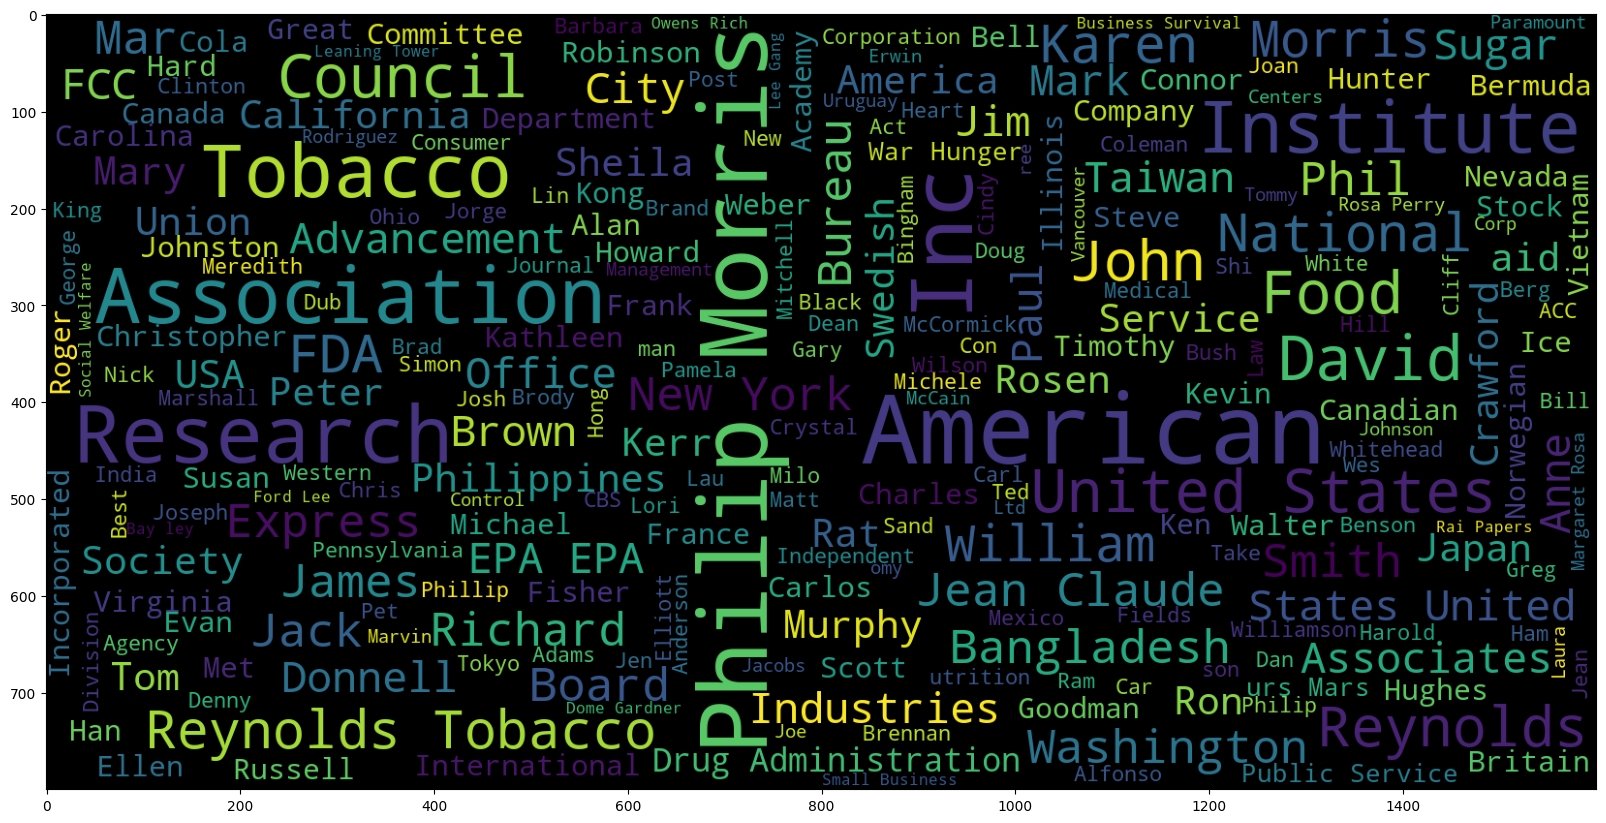

In [82]:
import wordcloud
wc = wordcloud.WordCloud(background_color = 'black', max_words = 250, max_font_size = 100, width=1600, height=800)
haute_conf_mot_str = ''
for i in haute_conf_mot:
    haute_conf_mot_str += i + ' '
wc.generate(haute_conf_mot_str)
plt.figure(figsize = (20,20))
plt.imshow(wc);

### WordCloud avec uniquement les personnes (confiance > 0.999)

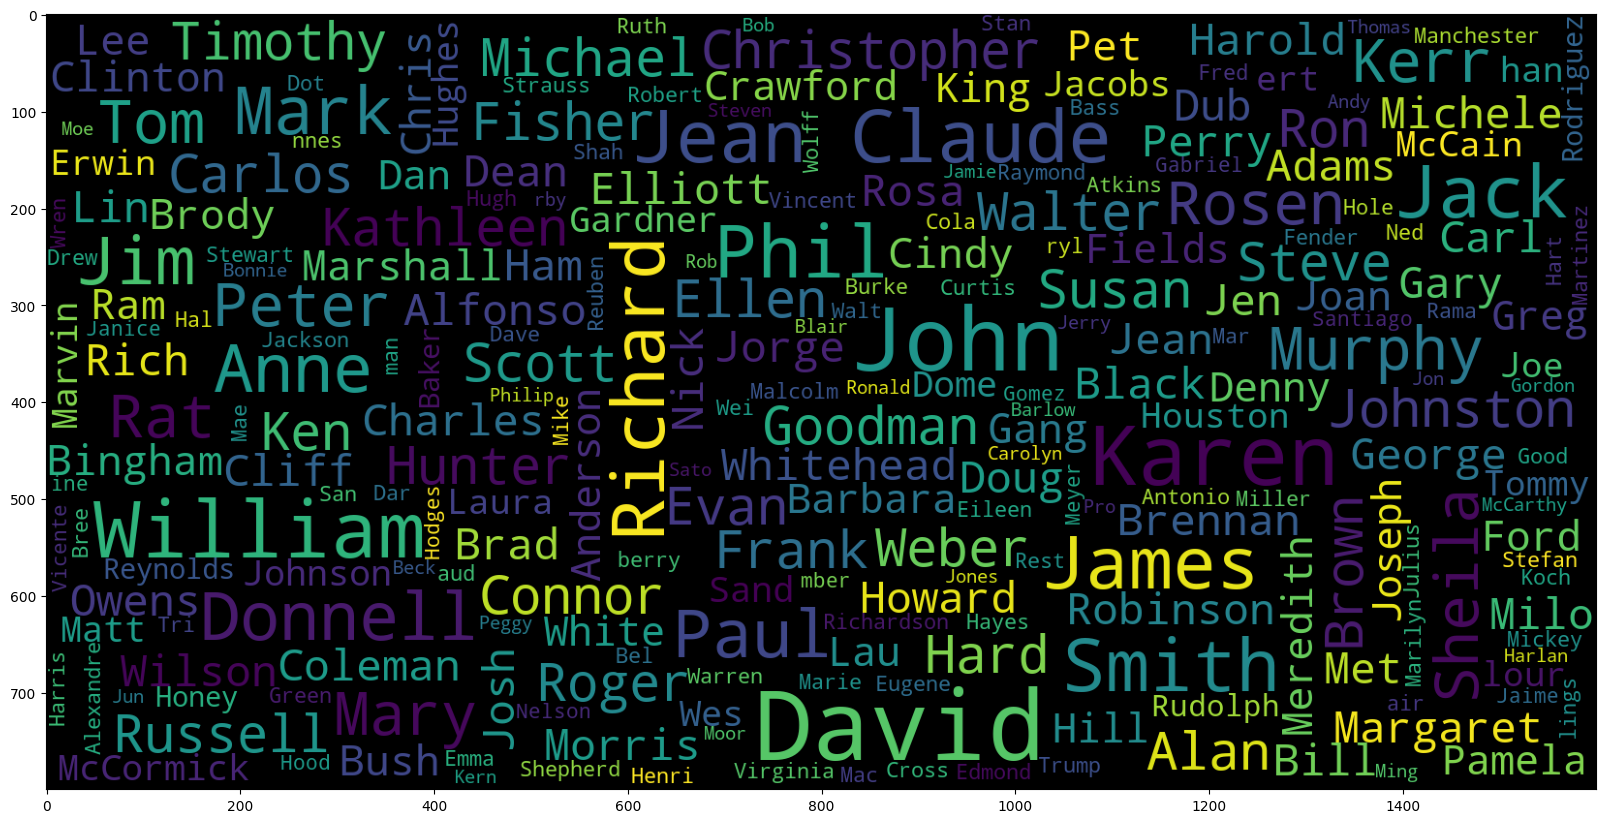

In [87]:
hauteconf_pers = []
for i in range(len(haute_conf_mot)):
    if haute_conf_type[i] == 'I-PER':
        hauteconf_pers.append(haute_conf_mot[i])
hauteconf_pers_str = ''
for i in hauteconf_pers:
    hauteconf_pers_str += i + ' '
wc.generate(hauteconf_pers_str)
plt.figure(figsize = (20,20))
plt.imshow(wc);


### WordCloud avec uniquement les lieux (conf > 0.999)

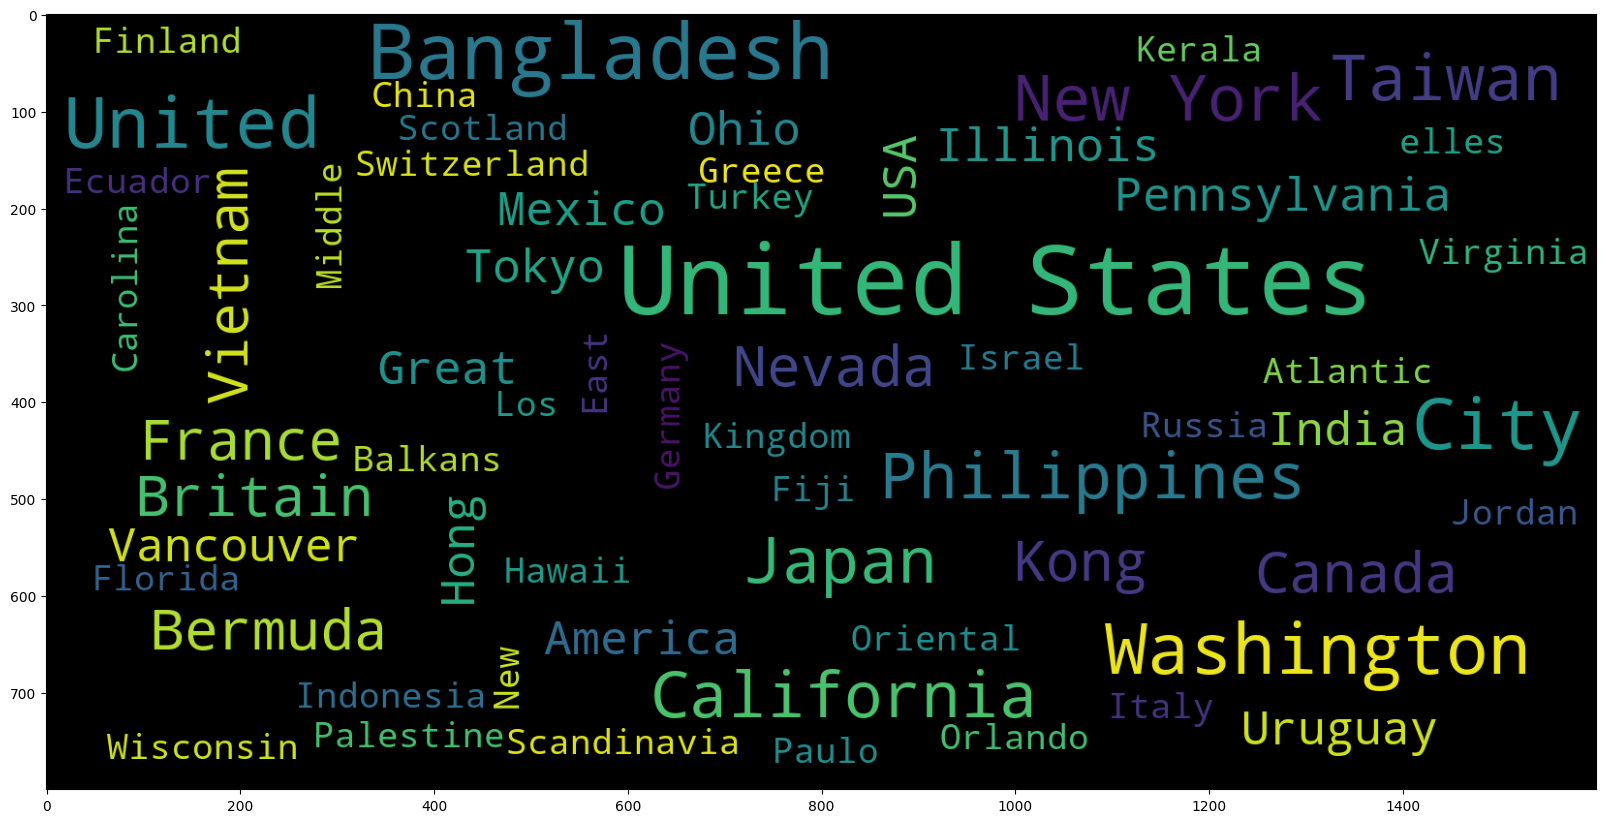

In [88]:
hauteconf_lieu = []
for i in range(len(haute_conf_mot)):
    if haute_conf_type[i] == 'I-LOC':
        hauteconf_lieu.append(haute_conf_mot[i])
hauteconf_lieu_str = ''
for i in hauteconf_lieu:
    hauteconf_lieu_str += i + ' '
wc.generate(hauteconf_lieu_str)
plt.figure(figsize = (20,20))
plt.imshow(wc);

### WordCloud avec uniquement les organisations (conf > 0.999)

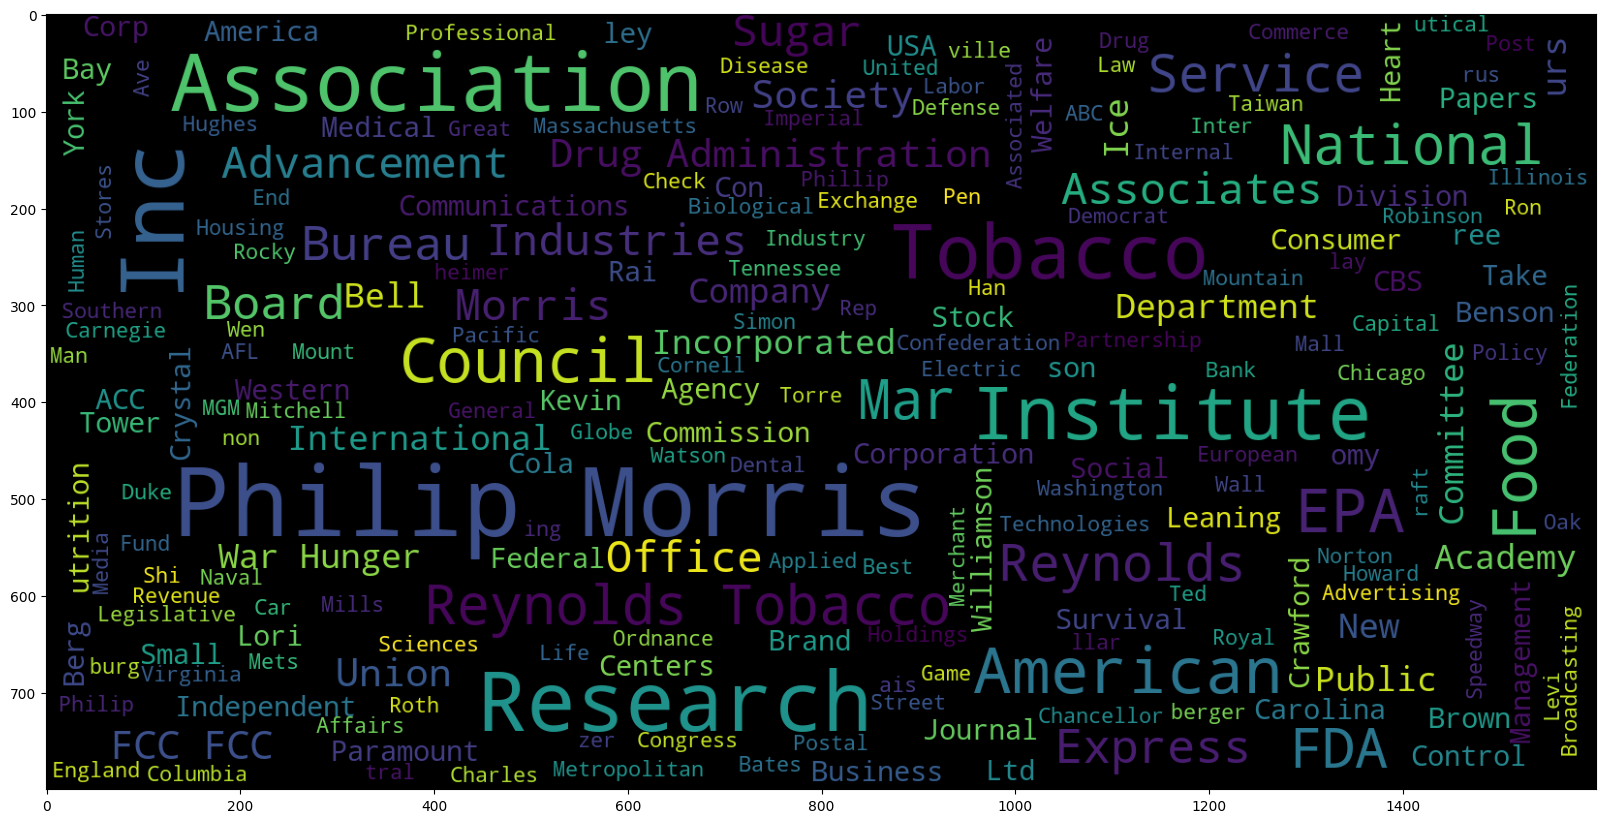

In [89]:
hauteconf_org = []
for i in range(len(haute_conf_mot)):
    if haute_conf_type[i] == 'I-ORG':
        hauteconf_org.append(haute_conf_mot[i])
hauteconf_org_str = ''
for i in hauteconf_org:
    hauteconf_org_str += i + ' '
wc.generate(hauteconf_org_str)
plt.figure(figsize = (20,20))
plt.imshow(wc);